# Attempt 5

In [1119]:
import os
import math
import time
import torch
import gpytorch
import numpy as np
import random as rnd

from matplotlib import pyplot as plt

# randomizes the datapoint inputs every run
np.random.seed(0) 
#np.random.seed(rnd.randint(0, 1000000)) # deactivated the randomizer for simplicity during testing

# timer module to calculate run time
time_start = time.time() 

# Stage 0: Setting up HF and LF data sets

In [1120]:
# Training data is 1000 points in [0,1] inclusive regularly spaced
X = torch.linspace(0, 1, 1000)

# defines the HF and LF sine functions. Gaussian noise was excluded for simplicity during testing
def hf(x): 
    return 1.8*torch.sin(x * (8 * math.pi))*2*x # + torch.randn(x.size()) * math.sqrt(0.04) #* the accurately simulated sin model for HF data

def lf(x):
    return torch.sin(x * (8 * math.pi))*x # + torch.randn(x.size()) * math.sqrt(0.04) #* the inaccurately simulated sin model for LF data

# Setting the number of LF and HF points
Nlf=40
Nhf=8

#Sampling LF and HF model randomly
X_lf = np.random.permutation(X)[0:Nlf] # basically randomly aranges the 50 different values in X array, from 0 to "len(Nlf)"
X_hf = np.random.permutation(X_lf)[0:Nhf]

# Converting np.ndarray to tensor to be able to utilize GPyTorch
X_lf = torch.from_numpy(X_lf)
X_hf = torch.from_numpy(X_hf) 

# Stage 1: HF Modelling using Exact Gaussian Process Model

In [1121]:
train_x = X_hf 
train_y = hf(X_hf) 

#! Setting up the HF Model
class ExactGPModel_HF(gpytorch.models.ExactGP): 
    def __init__(self, train_x, train_y, likelihood): 
        super(ExactGPModel_HF, self).__init__(train_x, train_y, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # This is the object used to represent multivariate normal distributions.
        # multivariate Gaussian distribution, or joint normal distribution is a generalization of the one-dimensional normal distribution to higher dimensions.


 #! Setting up the training and the likelihood of the model
training_iter = 300

likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model = ExactGPModel_HF(train_x, train_y, likelihood) 

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter

 #! Training the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)

    loss.backward() # Computes the gradient and stores them in the tensors once you call .backward() 

    optimizer.step()

 #! Making HF predictions with the HF model
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(model(test_x)) 
    
observed_pred_mean = observed_pred.mean
print(observed_pred_mean.size())

torch.Size([1000])


# Stage 2: LF Model Modelling using Exact Gaussian Process Model

In [1122]:
train_X_lf = X_lf 
train_Y_lf = lf(X_lf) 

class ExactGPModel_LF(gpytorch.models.ExactGP): 
    def __init__(self, train_X_lf, train_Y_lf, likelihood): 
        super(ExactGPModel_LF, self).__init__(train_X_lf, train_Y_lf, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model_LF = ExactGPModel_LF(train_X_lf, train_Y_lf, likelihood) 

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter


# train the model and likelihood
model_LF.train()
likelihood.train()

optimizer = torch.optim.Adam(model_LF.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_LF)

for i in range(training_iter):
    optimizer.zero_grad()

    output = model_LF(train_X_lf)

    loss = -mll(output, train_Y_lf)

    loss.backward()
    optimizer.step()

model_LF.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x2 = X
    observed_pred2 = likelihood(model_LF(test_x2))

    observed_pred2_mean = observed_pred2.mean
    # print(observed_pred2_mean)
    print(observed_pred2_mean.size())

torch.Size([1000])


# Stage 3: MF Modelling Stage 
Using LF model and HF points, predict an L1mean

In [1123]:
 #! STAGE ONE OF MF MODEL, USING LF PREDICT HF POINTS

train_x3 = X_lf
train_y3 = lf(X_lf)

# Inserting HF points into LF Model
with torch.no_grad(), gpytorch.settings.fast_pred_var(): 
    test_HF = X_hf
    observed_pred3 = likelihood(model_LF(test_HF)) 

observed_pred3_mean = observed_pred3.mean
# print(observed_pred3_mean)

L2_train = torch.stack([X_hf, observed_pred3_mean],-1)

# print(L2_train)
print(L2_train.size())

torch.Size([8, 2])


In [1124]:
 #! STAGE TWO, USING A NEW MF MODEL, PREDICT L2TRAIN OVER HF 

train_X_MF = L2_train
train_Y_MF = hf(X_hf)
print(train_X_MF.size())


#! Setting up the MULTIFIDELITY Model
class ExactGPModel_MF(gpytorch.models.ExactGP): 
    def __init__(self, train_X_MF, train_Y_MF, likelihood): 
        super(ExactGPModel_MF, self).__init__(train_X_MF, train_Y_MF, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # This is the object used to represent multivariate normal distributions.
        # multivariate Gaussian distribution, or joint normal distribution is a generalization of the one-dimensional normal distribution to higher dimensions.

likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model_MF = ExactGPModel_MF(train_X_MF, train_Y_MF, likelihood) 

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter


 #! Training the model
model_MF.train()
likelihood.train()

optimizer = torch.optim.Adam(model_MF.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_MF)

for i in range(training_iter):

    optimizer.zero_grad()

    output = model_MF(train_X_MF)

    loss = -mll(output, train_Y_MF)
    loss.backward()

    optimizer.step()

model_MF.eval()
likelihood.eval()

 #! BEFORE GETTING observed_pred4 WE NEED TO CREATE L2_TEST USING X AND observed_pred2 (from LF model)
 #! REPEAT WHAT YOU DID FOR L2_TRAIN

L2_test = torch.stack([X, observed_pred2_mean],-1)

print(L2_test.size())

 #! Then you can carry on with the observed_pred4
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x_MF = L2_test
    observed_pred4 = likelihood(model_MF(test_x_MF)) 

observed_pred4_mean = observed_pred4.mean
print(observed_pred4_mean.size())


torch.Size([8, 2])
torch.Size([1000, 2])
torch.Size([1000])


In [1125]:
  
#  #!--------------------------------------------------------------
# likelihood = gpytorch.likelihoods.GaussianLikelihood() 
# model_4 = ExactGPModel_MF(train_X_MF, train_Y_MF, likelihood)

# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else training_iter


# #--------------------------------------------------------------


# model_4.train()
# likelihood.train()

# optimizer = torch.optim.Adam(model_4.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_4)

# for i in range(training_iter):

#     optimizer.zero_grad()

#     output = model_4(train_x4)

#     loss = -mll(output, train_y4)

#     loss.sum().backward()
#     # loss.backward(torch.Tensor([1, 1]))

#     optimizer.step()

# model_4.eval()
# likelihood.eval()


# X = X.numpy()
# X = X[:,np.newaxis]


# observed_pred2_mean = observed_pred2_mean.numpy()
# observed_pred2_mean = observed_pred2_mean[:,np.newaxis]


# L2_test = np.hstack((X, observed_pred2_mean))


# print(len(L2_test))

# # HF points getting trained by LF model
# with torch.no_grad(), gpytorch.settings.fast_pred_var(): 
#     test_x4 = torch.tensor(L2_test)

#     observed_pred4 = likelihood(model_4(test_x4)) 

# observed_pred4_mean = observed_pred4.mean
# print(len(observed_pred4_mean))



        
# #--------------------------------------------------------------
# likelihood = gpytorch.likelihoods.GaussianLikelihood() 
# model_4 = ExactGPModel(train_x4, train_y4, likelihood)

# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else training_iter


# #--------------------------------------------------------------


# model_4.train()
# likelihood.train()

# optimizer = torch.optim.Adam(model_4.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_4)

# for i in range(training_iter):

#     optimizer.zero_grad()

#     output = model_4(train_x4)

#     loss = -mll(output, train_y4)

#     loss.sum().backward()
#     # loss.backward(torch.Tensor([1, 1]))

#     optimizer.step()

# model_4.eval()
# likelihood.eval()


# X = X.numpy()
# X = X[:,np.newaxis]


# observed_pred2_mean = observed_pred2_mean.numpy()
# observed_pred2_mean = observed_pred2_mean[:,np.newaxis]


# L2_test = np.hstack((X, observed_pred2_mean))


# print(len(L2_test))

# # HF points getting trained by LF model
# with torch.no_grad(), gpytorch.settings.fast_pred_var(): 
#     test_x4 = torch.tensor(L2_test)

#     observed_pred4 = likelihood(model_4(test_x4)) 

# observed_pred4_mean = observed_pred4.mean
# print(len(observed_pred4_mean))


# # reshape the pred4_mean to plot
# observed_pred4_mean = torch.flip(observed_pred4_mean, [0,1])
# observed_pred4_mean = observed_pred4_mean.reshape(-1,1)
# print((observed_pred4_mean.size()))

# observed_pred4_mean = observed_pred4_mean[0:1000,:]
# print((observed_pred4_mean.size()))



# # Fix the X and observed_pred2_mean back to tensors
# X = torch.tensor(X)
# observed_pred2_mean = torch.tensor(observed_pred2_mean)


# Stage 4: Plotting

1000
Finished in 5.027395248413086 seconds.


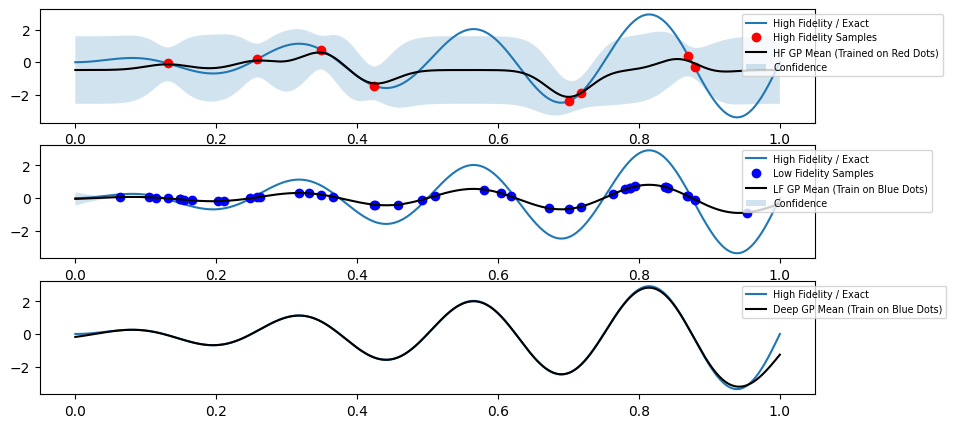

In [1126]:
from telnetlib import PRAGMA_HEARTBEAT


with torch.no_grad():
    f, ax = plt.subplots(3, figsize = (10, 5))

    # Get upper and lower confidence bounds
    lower,  upper  =  observed_pred.confidence_region()
    lower2, upper2 = observed_pred2.confidence_region()
    lower3, upper3 = observed_pred3.confidence_region()
    lower4, upper4 = observed_pred4.confidence_region()
    
    #High Fidelity / Exact Line
    ax[0].plot(X,hf(X), label="High Fidelity / Exact")
    ax[1].plot(X,hf(X), label="High Fidelity / Exact")
    ax[2].plot(X,hf(X), label="High Fidelity / Exact")

    # Sample Points
    ax[0].plot(train_x.numpy(),train_y.numpy(), 'ro',label="High Fidelity Samples")
    # ax[1].plot(train_x2.numpy(),train_y2.numpy(), 'bo', label="Low Fidelity Samples")
    ax[1].plot(train_X_lf.numpy(),train_Y_lf.numpy(), 'bo', label="Low Fidelity Samples")
   
    # GP Mean PREDICTIONS
    ax[0].plot(test_x.numpy(),observed_pred.mean.numpy(), 'k', label = "HF GP Mean (Trained on Red Dots)")
    ax[1].plot(test_x2.numpy(),observed_pred2.mean.numpy(), 'k', label = "LF GP Mean (Train on Blue Dots)")
    ax[2].plot(X.numpy(),observed_pred4_mean.numpy(), 'k', label = "Deep GP Mean (Train on Blue Dots)")
    
    print(len(test_x_MF))

    # # Shade between the lower and upper confidence bounds
    ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, label = "Confidence")
    ax[1].fill_between(test_x2.numpy(), lower2.numpy(), upper2.numpy(), alpha=0.2, label = "Confidence") 
   
    #Legends
    ax[2].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')
    ax[1].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')
    ax[0].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')

abs_path = os.path.abspath('')
dir = os.path.dirname(abs_path)

plt.savefig(abs_path + "\\attempt_2_plot.pdf")
print(f"Finished in {(time.time() - time_start)} seconds." )